## 1. Формулировка

#### 1.1 Описание задачи

Named Entity Recognition (распознавание именованных сущностей) — это задача автоматического выявления и классификации сущностей в тексте.

В данной задаче нужно выделить и классифицировать следующие классы сущностей:

- PER — персоналии (люди)
- ORG — организации
- LOC — географические объекты
- EVT — события
- PRO — процессы

**Пример:**

> "Тереза Мэй выступила в Парламенте Великобритании после саммита ЕС."

```python

entities = [
    ("Тереза Мэй", "PER"),
    ("Парламент Великобритании", "ORG"),
    ("ЕС", "ORG"),
    ("саммит", "EVT")
]
```

#### 1.2 Классические Методы

1. **Rule-based**

Написание шаблонов/паттернов и/или составление списков сущностей.

2. **Машинное Обучение**

- HMM (Hidden Markov Model) - татистическая модель, используемая для анализа последовательностей данных, где наблюдаемые события зависят от скрытых.
- CRF (Conditional Random Fields) - использует случайно заведённые признаки слов/токенов. Например, морфология слов, регистр, пунктуция, POS-теги или приндлежность к списку других сущностей

3. **Глубокое Обучение**

- BiLSTM (Biderectional Long-Short Term Memory) - достаточна легвоесная архитектура, для разного рода задач над последовательностями.

- BERT (Biderctional Encoder Representations from Transformers) - более весомая архитектура, обращающая внимание с обеих сторон и автоматически извлекающая признаки (не интрепретируемые в большинстве своём).

#### 1.3 Решение через LLM

Подход через prompt engineering:

1. Prompt "Извлеки все сущности из следующего текста. Укажи тип (PER, ORG, LOC, EVT, PRO) для каждой сущности."
2. Загружаем в модель prompt + текст
3. Получаем структурированный ответ (например в json)

#### 1.4 Оценка качества

Имеем тестовый датасет, который не попадал в трейн.

По нему можно собрать классические метрики:

$$
Precision = \frac{TP}{TP + FP}
$$

$$
Recall = \frac{TP}{TP + FN}
$$

$$
F_1 = 2 * \frac{Precision * Recall}{Precision + Recall}
$$

Также можем выделить разные уровни агрегации:

- По документам
- По типу сущностей
- Общая макро/микро усреднённая метрика (зависит от дизбаланса присутсвия классов)


## 2. Чтение


In [1]:
import pandas as pd
from pathlib import Path


def get_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []

    raw_files = sorted((dataset_path / "raw" / "ru").glob("*.txt"))
    for raw_file in raw_files:
        with open(raw_file, encoding="utf-8") as f:
            lines = [line.strip() for line in f.readlines()]
            if len(lines) >= 5:
                data.append(
                    {
                        "document_id": lines[0],
                        "language": lines[1],
                        "creation_date": lines[2],
                        "url": lines[3],
                        "title": lines[4],
                        "document_text": "\n".join(lines[5:]),
                    }
                )

    df = pd.DataFrame(data)

    # Entities and gold answers
    entity_data = []
    gold_data = []

    annotated_files = sorted((dataset_path / "annotated" / "ru").glob("*.out"))
    for annotated_file in annotated_files:
        entities = []
        with open(annotated_file, encoding="utf-8") as f:
            lines = [line.strip() for line in f.readlines()]
            # Skip the first line (document_id)
            for line in lines[1:]:
                if line:
                    parts = line.split("\t")
                    if len(parts) >= 3:
                        mention, base_form, category = parts[:3]
                        entities.append(
                            {
                                "mention": mention,
                                "base_form": base_form,
                                "category": category,
                            }
                        )
        if entities:
            entity_data.append([e["mention"] for e in entities])
            gold_data.append([e["category"] for e in entities])
        else:
            entity_data.append([])
            gold_data.append([])

    df["entity"] = entity_data
    df["gold_answer"] = gold_data

    return df

In [2]:
dataset_path = Path("sample_pl_cs_ru_bg")
df = get_dataframe(dataset_path)
df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ..."
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]"
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ..."
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ..."
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"[Brexit, Facebook, Борис Джонсон, Бориса Джонс...","[EVT, PRO, PER, PER, LOC, LOC, PER, PER, PER, ..."
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, LOC, PER, PER, ..."
8,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста министр...,\nКИЕВ. 9 июля. УНН. Борис Джонсон подал в отс...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, PER, LOC, PER, PER, ..."


## 3-4. LLM


In [3]:
import yaml

with open("config.yaml") as config_file:
    config = yaml.safe_load(config_file)

for k, v in config.items():
    print(f"{k}: {len(v) * '*'}")

client_id: ************************************
client_secret: ************************************
scope: *****************
auth_key: ****************************************************************************************************


Добавляем сертификат минцифры (для линукса)

In [66]:
!curl -k "https://gu-st.ru/content/Other/doc/russian_trusted_root_ca.cer" -w "\n" >> $(python3 -m certifi)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2088    0  2088    0     0  61764      0 --:--:-- --:--:-- --:--:-- 63272


Получаем access token

In [67]:
import requests
import uuid
import json

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload = {"scope": "GIGACHAT_API_PERS"}
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json",
    "RqUID": str(uuid.uuid4()),
    "Authorization": f"Basic {config['auth_key']}",
}

response = requests.request(
    method="POST",
    url=url,
    headers=headers,
    data=payload,
)

if response.ok:
    response_dict = json.loads(response.text)
    config.update(response_dict)
else:
    raise ValueError("No access token available")

In [68]:
from langchain_gigachat.chat_models import GigaChat
from langchain_core.language_models import BaseChatModel
from langchain.prompts import load_prompt, BasePromptTemplate

giga = GigaChat(
    credentials=config["auth_key"],
    scope=config["scope"],
    access_token=config["access_token"],
    model="GigaChat-2-Pro",
    # Greed decoding
    temperature=0,
)

prompt = load_prompt("template.yaml")
print(prompt)

input_variables=['text'] input_types={} partial_variables={} template='Проанализируй следующий текст и извлеки все пары наименованных сущностей, относящихся к следующим классам:\n- PER — персоналии (люди)\n- ORG — организации\n- LOC — географические объекты\n- EVT — события\n- PRO — процессы\n\nПредставь результат в виде JSON, соответствующего следующей модели Pydantic:\n\n```python\nfrom pydantic import BaseModel, Field\nfrom typing import List\n\nclass Pair(BaseModel):\n    entity: str = Field(..., description="Наименованная сущность")\n    answer: str = Field(..., description="Класс сущности (PER, ORG, LOC, EVT, PRO)")\n\nclass Response(BaseModel):\n    pairs: List[Pair]\n```\n\nТекст для анализа:\n{text}\n\nВыведи ТОЛЬКО JSON, соответсвующей pydantic модели и ничего больше!\n'


In [69]:
response = giga.get_models()

for model in response.data:
    print(model.id_)
# print(response)

GigaChat
GigaChat-2
GigaChat-2-Max
GigaChat-2-Max-preview
GigaChat-2-Pro
GigaChat-2-Pro-preview
GigaChat-2-preview
GigaChat-Max
GigaChat-Max-preview
GigaChat-Plus
GigaChat-Plus-preview
GigaChat-Pro
GigaChat-Pro-preview
GigaChat-preview
Embeddings
Embeddings-2
EmbeddingsGigaR


In [70]:
from langchain_core.output_parsers import JsonOutputParser, BaseOutputParser

from pydantic import BaseModel, Field
from typing import List


class Pair(BaseModel):
    entity: str = Field(..., description="Наименованная сущность")
    answer: str = Field(..., description="Класс сущности (PER, ORG, LOC, EVT, PRO)")


class Response(BaseModel):
    pairs: List[Pair]


parser = JsonOutputParser(pydantic_object=Response)

In [71]:
def ask_llm_for_ner(
    model: BaseChatModel,
    prompt: BasePromptTemplate,
    parser: BaseOutputParser,
    text: str,
):
    prompt.partial_variables["format_insturctions"] = parser.get_format_instructions()
    chain = prompt | model | parser
    return chain.invoke({"text": text})

In [72]:
def process_row(row):
    result: Response = ask_llm_for_ner(giga, prompt, parser, row["document_text"])

    pairs = result["pairs"]
    entities = [pair["entity"] for pair in pairs]
    answers = [pair["answer"] for pair in pairs]
    assert len(entities) == len(
        answers
    ), "Entities and their classes should have the same length"

    return entities, answers


df[["entities", "answers"]] = df.apply(process_row, axis=1, result_type="expand")

In [73]:
df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Борис Джонсон, Мишель Барнье, Себастьян Курц,...","[PER, PER, PER, PER, ORG, ORG, ORG, ORG, ORG, ..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...","[PER, PER, PER, PER, LOC, ORG, LOC, PER, ORG, ..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Борис Джонсон, Тереза Мэй, Великобритания, As...","[PER, PER, LOC, ORG, LOC, ORG, EVT]"
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]","[Тереза Мей, Борис Джонсон, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, PER]"
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[агентство Рейтер, Тереза Мэй, Даунинг-Стрит, ...","[ORG, PER, LOC, PER, LOC, ORG, PER, EVT]"
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ...","[Борис Джонсон, МИД Великобритании, ТАСС, Тере...","[PER, ORG, ORG, PER, PER, EVT, ORG, LOC, EVT, ..."
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"[Brexit, Facebook, Борис Джонсон, Бориса Джонс...","[EVT, PRO, PER, PER, LOC, LOC, PER, PER, PER, ...","[Мария Захарова, МИД России, Борис Джонсон, Ве...","[PER, ORG, PER, LOC, PER, ORG, PER, ORG, PER, ..."
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, LOC, PER, PER, ...","[Борис Джонсон, Тереза Мэй, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, EVT, PER, ORG]"
8,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста министр...,\nКИЕВ. 9 июля. УНН. Борис Джонсон подал в отс...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, PER, LOC, PER, PER, ...","[Борис Джонсон, The Guardian, УНН, Великобрита...","[PER, ORG, ORG, LOC, ORG, PER, PER, PER, LOC, ..."


In [74]:
df.to_csv("results.csv", header=True, index=False)

In [4]:
df = pd.read_csv("results.csv")
df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","['Brexit', 'Альбиона', 'Альбионе', 'Борис Джон...","['EVT', 'LOC', 'LOC', 'PER', 'LOC', 'LOC', 'LO...","['Борис Джонсон', 'Мишель Барнье', 'Себастьян ...","['PER', 'PER', 'PER', 'PER', 'ORG', 'ORG', 'OR..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","['Brexit', 'The Guardian', 'Борис Джонсон', 'Б...","['EVT', 'PRO', 'PER', 'PER', 'PER', 'LOC', 'PE...","['Джонсон', 'Дэвид Дэвис', 'Стив Бейкер', 'Тер...","['PER', 'PER', 'PER', 'PER', 'LOC', 'ORG', 'LO..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"['Associated Press', 'Brexit', 'Борис Джонсон'...","['ORG', 'EVT', 'PER', 'PER', 'LOC', 'PER', 'PE...","['Борис Джонсон', 'Тереза Мэй', 'Великобритани...","['PER', 'PER', 'LOC', 'ORG', 'LOC', 'ORG', 'EVT']"
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"['Бориса Джонсона', 'Брекзит', 'Великобритании...","['PER', 'EVT', 'LOC', 'PER', 'ORG', 'ORG', 'PER']","['Тереза Мей', 'Борис Джонсон', 'Великобритани...","['PER', 'PER', 'LOC', 'ORG', 'ORG', 'PER']"
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"['Борис Джонсон', 'Великобритании', 'Даунинг-С...","['PER', 'LOC', 'LOC', 'PER', 'PER', 'ORG', 'PE...","['агентство Рейтер', 'Тереза Мэй', 'Даунинг-Ст...","['ORG', 'PER', 'LOC', 'PER', 'LOC', 'ORG', 'PE..."
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"['Brexit', 'Борис Джонсон', 'Германии', 'Джонс...","['EVT', 'PER', 'LOC', 'PER', 'PER', 'PER', 'PE...","['Борис Джонсон', 'МИД Великобритании', 'ТАСС'...","['PER', 'ORG', 'ORG', 'PER', 'PER', 'EVT', 'OR..."
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"['Brexit', 'Facebook', 'Борис Джонсон', 'Борис...","['EVT', 'PRO', 'PER', 'PER', 'LOC', 'LOC', 'PE...","['Мария Захарова', 'МИД России', 'Борис Джонсо...","['PER', 'ORG', 'PER', 'LOC', 'PER', 'ORG', 'PE..."
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"['Brexit', 'The Guardian', 'Борис Джонсон', 'Б...","['EVT', 'PRO', 'PER', 'PER', 'PER', 'LOC', 'LO...","['Борис Джонсон', 'Тереза Мэй', 'Великобритани...","['PER', 'PER', 'LOC', 'ORG', 'ORG', 'EVT', 'PE..."
8,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста министр...,\nКИЕВ. 9 июля. УНН. Борис Джонсон подал в отс...,"['Brexit', 'The Guardian', 'Борис Джонсон', 'Б...","['EVT', 'PRO', 'PER', 'PER', 'PER', 'PER', 'LO...","['Борис Джонсон', 'The Guardian', 'УНН', 'Вели...","['PER', 'ORG', 'ORG', 'LOC', 'ORG', 'PER', 'PE..."


Заметим, что эти листы хранятся как строки, что не очевидно. Приведём к листам


In [5]:
import ast


def parse_list_from_string(list_string: str):
    try:
        # Safely evaluate the string to a Python object
        python_list = ast.literal_eval(list_string)
        # Ensure the result is a list
        if isinstance(python_list, list):
            return python_list
        else:
            raise ValueError("The string does not represent a list.")
    except (ValueError, SyntaxError):
        raise ValueError("Invalid list string.")


should_be_list_columns = ["entity", "gold_answer", "entities", "answers"]

for column in should_be_list_columns:
    df[column] = df[column].apply(parse_list_from_string)

df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Борис Джонсон, Мишель Барнье, Себастьян Курц,...","[PER, PER, PER, PER, ORG, ORG, ORG, ORG, ORG, ..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...","[PER, PER, PER, PER, LOC, ORG, LOC, PER, ORG, ..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Борис Джонсон, Тереза Мэй, Великобритания, As...","[PER, PER, LOC, ORG, LOC, ORG, EVT]"
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]","[Тереза Мей, Борис Джонсон, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, PER]"
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[агентство Рейтер, Тереза Мэй, Даунинг-Стрит, ...","[ORG, PER, LOC, PER, LOC, ORG, PER, EVT]"
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ...","[Борис Джонсон, МИД Великобритании, ТАСС, Тере...","[PER, ORG, ORG, PER, PER, EVT, ORG, LOC, EVT, ..."
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"[Brexit, Facebook, Борис Джонсон, Бориса Джонс...","[EVT, PRO, PER, PER, LOC, LOC, PER, PER, PER, ...","[Мария Захарова, МИД России, Борис Джонсон, Ве...","[PER, ORG, PER, LOC, PER, ORG, PER, ORG, PER, ..."
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, LOC, PER, PER, ...","[Борис Джонсон, Тереза Мэй, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, EVT, PER, ORG]"
8,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста министр...,\nКИЕВ. 9 июля. УНН. Борис Джонсон подал в отс...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, PER, LOC, PER, PER, ...","[Борис Джонсон, The Guardian, УНН, Великобрита...","[PER, ORG, ORG, LOC, ORG, PER, PER, PER, LOC, ..."


## 5. Метрики

Поскольку в нашей метрики хочется сохранить как и точность, так и полноту, то будем использовать f1-меру как основную метрику.

- (Хотим одновременно ухватить все сущности - уменьшить FN = увеличить полноту)
- (Так и одновременно не сильно хватать лишние сущности - уменьшить FP = увеличить точность)

Также стоит отметить, что перед вычислением метрики, текст стоит нормализовать. Русский язык славится своими морфологией, поэтому для качественного сравнения извлечённых и имеющихся слов, надо их нормализовать. (Например, "Бориса Джонсона" должно быть равно "Борис Джонсон")


In [6]:
import pymorphy3


def normalize_entity(entity: str) -> str:
    morph = pymorphy3.MorphAnalyzer(lang="ru")
    normalized = []
    for word in entity.split():
        parsed = morph.parse(word)[0]
        normalized.append(parsed.normal_form)
    return " ".join(normalized)


normalize_entity("Бориса Джонсона")

'борис джонсон'

In [7]:
row = df[df["document_id"] == "ru-1002"]
true_entity = row["entity"].values[0]
true_answer = row["gold_answer"].values[0]
pred_entity = row["entities"].values[0]
pred_answer = row["answers"].values[0]

print(true_entity)
print(pred_entity)
print()
print(true_answer)
print(pred_answer)

['Бориса Джонсона', 'Брекзит', 'Великобритании', 'Дэвид Дэвис', 'ЕС', 'Евросоюза', 'Тереза Мей']
['Тереза Мей', 'Борис Джонсон', 'Великобритания', 'ЕС', 'Евросоюз', 'Дэвид Дэвис']

['PER', 'EVT', 'LOC', 'PER', 'ORG', 'ORG', 'PER']
['PER', 'PER', 'LOC', 'ORG', 'ORG', 'PER']


In [8]:
def f1(true_entities, true_labels, pred_entities, pred_labels, normalize: bool = False):
    if normalize:
        true_entities = list(map(normalize_entity, true_entities))
        pred_entities = list(map(normalize_entity, pred_entities))

    true_set = set(zip(true_entities, true_labels))
    pred_set = set(zip(pred_entities, pred_labels))

    tp = len(true_set & pred_set)
    fp = len(pred_set - true_set)
    fn = len(true_set - pred_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0.0
    )

    return f1

In [9]:
f1(
    true_entity,
    true_answer,
    pred_entity,
    pred_answer,
)

0.4615384615384615

Давайте теперь применим нормализацию слов


In [10]:
true_entity = list(map(normalize_entity, true_entity))
pred_entity = list(map(normalize_entity, pred_entity))
true_entity, pred_entity

(['борис джонсон',
  'брекзита',
  'великобритания',
  'дэвид дэвис',
  'ес',
  'евросоюз',
  'тереза мей'],
 ['тереза мей',
  'борис джонсон',
  'великобритания',
  'ес',
  'евросоюз',
  'дэвид дэвис'])

In [11]:
f1(
    true_entity,
    true_answer,
    pred_entity,
    pred_answer,
    normalize=True,
)

0.923076923076923

Сама метрика f1 реализовано следующим правилом:

Сделаем 2 множества из пар (**<нормализованная сущность>**, **<метка>**)

- TP = intersection этих множеств, тоесть все пары присутствующие в обоих множествах с одинаковыми метками
- FP = из предсказаного множества вычитаем gold answer, что есть множеств всех предсказанных сущностей, которых на самом деле извлекать не надо было (они не были сущностями)
- FN = вычитаем из gold answer предсказание, тоесть получаем все пары, которые нам не хватило правильно предсказать (либо метка отличается, либо сущность в целом не была предсказана)


In [12]:
true_set = set(zip(true_entity, true_answer))
pred_set = set(zip(pred_entity, pred_answer))

print(true_set)
print(pred_set)
print(true_set & pred_set)
print(pred_set - true_set)
print(true_set - pred_set)

{('дэвид дэвис', 'PER'), ('брекзита', 'EVT'), ('евросоюз', 'ORG'), ('тереза мей', 'PER'), ('ес', 'ORG'), ('борис джонсон', 'PER'), ('великобритания', 'LOC')}
{('дэвид дэвис', 'PER'), ('евросоюз', 'ORG'), ('тереза мей', 'PER'), ('ес', 'ORG'), ('борис джонсон', 'PER'), ('великобритания', 'LOC')}
{('дэвид дэвис', 'PER'), ('евросоюз', 'ORG'), ('тереза мей', 'PER'), ('ес', 'ORG'), ('борис джонсон', 'PER'), ('великобритания', 'LOC')}
set()
{('брекзита', 'EVT')}


Векторная реализация может ускорить или например отсутвие запрета на библиотеки...


ЮнИт ТеСтЫЫЫЫЫ


In [15]:
def test_1():
    # Тест 1: Полное совпадение
    true_e = ["ЕС", "Дэвид Дэвис"]
    true_a = ["ORG", "PER"]
    pred_e = ["ЕС", "Дэвид Дэвис"]
    pred_a = ["ORG", "PER"]
    assert f1(true_e, true_a, pred_e, pred_a) == 1.0


def test_2():
    # Тест 2: Нет совпадений
    true_e = ["Брекзит"]
    true_a = ["EVT"]
    pred_e = ["Евросоюз"]
    pred_a = ["ORG"]
    assert f1(true_e, true_a, pred_e, pred_a) == 0.0


def test_3():
    true_entity = [
        "Бориса Джонсона",
        "Брекзит",
        "Великобритании",
        "Дэвид Дэвис",
        "ЕС",
        "Евросоюза",
        "Тереза Мей",
    ]
    true_answer = ["PER", "EVT", "LOC", "PER", "ORG", "ORG", "PER"]
    pred_entity = [
        "Тереза Мей",
        "Борис Джонсон",
        "Великобритания",
        "ЕС",
        "Евросоюз",
        "Дэвид Дэвис",
    ]
    pred_answer = ["PER", "PER", "LOC", "ORG", "ORG", "PER"]
    assert (
        abs(f1(true_entity, true_answer, pred_entity, pred_answer, normalize=True) - 0.92307) < 0.0001
    )


def test_4():
    # Тест 4: Пустые предсказания
    assert f1([], [], [], []) == 0.0


def test_5():
    # Тест 5: Частичные совпадения (только метки)
    true_e = ["Россия"]
    true_a = ["LOC"]
    pred_e = ["Великобритания"]  # Сущность отличается
    pred_a = ["LOC"]
    assert (
        f1(true_e, true_a, pred_e, pred_a) == 0.0
    )  # Сущности разные → не засчитывается


def test_6():
    # Тест 6: Ноль предсказаний при ненулевых true
    assert f1(["a"], ["X"], [], []) == 0.0


def test_7():
    # Тест 7: Ноль истинных при ненулевых предсказаниях
    assert f1([], [], ["a"], ["X"]) == 0.0

In [16]:
test_1()
test_2()
test_3()
test_4()
test_5()
test_6()
test_7()

## 6. Метрики по df, агрегации


In [17]:
def calculate_f1(row, normalize=False):
    true_e = row["entity"]
    true_a = row["gold_answer"]
    pred_e = row["entities"]
    pred_a = row["answers"]
    return f1(true_e, true_a, pred_e, pred_a, normalize)


df["f1"] = df.apply(lambda row: calculate_f1(row), axis=1)
df["f1_normalized"] = df.apply(lambda row: calculate_f1(row, True), axis=1)

In [18]:
df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers,f1,f1_normalized
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Борис Джонсон, Мишель Барнье, Себастьян Курц,...","[PER, PER, PER, PER, ORG, ORG, ORG, ORG, ORG, ...",0.215385,0.583333
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...","[PER, PER, PER, PER, LOC, ORG, LOC, PER, ORG, ...",0.538462,0.640000
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Борис Джонсон, Тереза Мэй, Великобритания, As...","[PER, PER, LOC, ORG, LOC, ORG, EVT]",0.400000,0.736842
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]","[Тереза Мей, Борис Джонсон, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, PER]",0.461538,0.923077
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[агентство Рейтер, Тереза Мэй, Даунинг-Стрит, ...","[ORG, PER, LOC, PER, LOC, ORG, PER, EVT]",0.444444,0.777778
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ...","[Борис Джонсон, МИД Великобритании, ТАСС, Тере...","[PER, ORG, ORG, PER, PER, EVT, ORG, LOC, EVT, ...",0.357143,0.666667
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"[Brexit, Facebook, Борис Джонсон, Бориса Джонс...","[EVT, PRO, PER, PER, LOC, LOC, PER, PER, PER, ...","[Мария Захарова, МИД России, Борис Джонсон, Ве...","[PER, ORG, PER, LOC, PER, ORG, PER, ORG, PER, ...",0.347826,0.476190
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, LOC, PER, PER, ...","[Борис Джонсон, Тереза Мэй, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, EVT, PER, ORG]",0.384615,0.700000
8,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста министр...,\nКИЕВ. 9 июля. УНН. Борис Джонсон подал в отс...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, PER, LOC, PER, PER, ...","[Борис Джонсон, The Guardian, УНН, Великобрита...","[PER, ORG, ORG, LOC, ORG, PER, PER, PER, LOC, ...",0.480000,0.583333


6.1 Агрегируем f1 по документам

Самый лёгкий способ агрегации - взять среднее метрик по документм


In [19]:
f1_mean = df["f1"].mean()
print(f"Mean F1 score: {f1_mean:.4f}")

f1_mean = df["f1_normalized"].mean()
print(f"Mean F1 Normalized score: {f1_mean:.4f}")

Mean F1 score: 0.4033
Mean F1 Normalized score: 0.6764


6.2 Агрегируем f1 по сущностям


In [20]:
df["entity_normalized"] = df["entity"].apply(
    lambda entities: [normalize_entity(e) for e in entities]
)
df["entities_normalized"] = df["entities"].apply(
    lambda entities: [normalize_entity(e) for e in entities]
)

df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers,f1,f1_normalized,entity_normalized,entities_normalized
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Борис Джонсон, Мишель Барнье, Себастьян Курц,...","[PER, PER, PER, PER, ORG, ORG, ORG, ORG, ORG, ...",0.215385,0.583333,"[brexit, альбион, альбион, борис джонсон, брит...","[борис джонсон, мишель барние, себастьян курц,..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...","[PER, PER, PER, PER, LOC, ORG, LOC, PER, ORG, ...",0.538462,0.640000,"[brexit, the guardian, борис джонсон, борис дж...","[джонсон, дэвид дэвис, стив бейкер, тереза мэй..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Борис Джонсон, Тереза Мэй, Великобритания, As...","[PER, PER, LOC, ORG, LOC, ORG, EVT]",0.400000,0.736842,"[associated press, brexit, борис джонсон, бори...","[борис джонсон, тереза мэй, великобритания, as..."
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]","[Тереза Мей, Борис Джонсон, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, PER]",0.461538,0.923077,"[борис джонсон, брекзита, великобритания, дэви...","[тереза мей, борис джонсон, великобритания, ес..."
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[агентство Рейтер, Тереза Мэй, Даунинг-Стрит, ...","[ORG, PER, LOC, PER, LOC, ORG, PER, EVT]",0.444444,0.777778,"[борис джонсон, великобритания, даунинга-стрит...","[агентство рейтер, тереза мэй, даунинга-стрит,..."
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ...","[Борис Джонсон, МИД Великобритании, ТАСС, Тере...","[PER, ORG, ORG, PER, PER, EVT, ORG, LOC, EVT, ...",0.357143,0.666667,"[brexit, борис джонсон, германия, джонсон, джо...","[борис джонсон, мид великобритания, тасс, тере..."
6,ru-1006,ru,2018-07-09,http://polit.ru/news/2018/07/09/zakharova/,Захарова лирически прокомментировала отставку ...,\nОфициальный представитель МИД России Мария З...,"[Brexit, Facebook, Борис Джонсон, Бориса Джонс...","[EVT, PRO, PER, PER, LOC, LOC, PER, PER, PER, ...","[Мария Захарова, МИД России, Борис Джонсон, Ве...","[PER, ORG, PER, LOC, PER, ORG, PER, ORG, PER, ...",0.347826,0.476190,"[brexit, facebook, борис джонсон, борис джонсо...","[мария захаров, мид россия, борис джонсон, вел..."
7,ru-1011,ru,2018-07-09,https://tsargrad.tv/news/za-borisom-dzhonsonom...,За Борисом Джонсоном последует сама Мэй - брит...,\nКомментируя отставку министра иностранных де...,"[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, LOC, PER, PER, ...","[Борис Джонсон, Тереза Мэй, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, EVT, PER, ORG]",0.384615,0.700000,"[bre

In [21]:
df["test_pair"] = df.apply(
    lambda row: list(zip(row["entity"], row["gold_answer"])), axis=1
)
df["pred_pair"] = df.apply(
    lambda row: list(zip(row["entities"], row["answers"])), axis=1
)

df["test_pair_normalized"] = df.apply(
    lambda row: list(zip(row["entity_normalized"], row["gold_answer"])), axis=1
)
df["pred_pair_normalized"] = df.apply(
    lambda row: list(zip(row["entities_normalized"], row["answers"])), axis=1
)

df

,document_id,language,creation_date,url,title,document_text,entity,gold_answer,entities,answers,f1,f1_normalized,entity_normalized,entities_normalized,test_pair,pred_pair,test_pair_normalized,pred_pair_normalized
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до зав...,"\nТем не менее, по сведениям британских СМИ, н...","[Brexit, Альбиона, Альбионе, Борис Джонсон, Бр...","[EVT, LOC, LOC, PER, LOC, LOC, LOC, LOC, LOC, ...","[Борис Джонсон, Мишель Барнье, Себастьян Курц,...","[PER, PER, PER, PER, ORG, ORG, ORG, ORG, ORG, ...",0.215385,0.583333,"[brexit, альбион, альбион, борис джонсон, брит...","[борис джонсон, мишель барние, себастьян курц,...","[(Brexit, EVT), (Альбиона, LOC), (Альбионе, LO...","[(Борис Джонсон, PER), (Мишель Барнье, PER), (...","[(brexit, EVT), (альбион, LOC), (альбион, LOC)...","[(борис джонсон, PER), (мишель барние, PER), (..."
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсон...,"\nТаким образом, Джонсон стал третьим министро...","[Brexit, The Guardian, Борис Джонсон, Бориса Д...","[EVT, PRO, PER, PER, PER, LOC, PER, PER, ORG, ...","[Джонсон, Дэвид Дэвис, Стив Бейкер, Тереза Мэй...","[PER, PER, PER, PER, LOC, ORG, LOC, PER, ORG, ...",0.538462,0.640000,"[brexit, the guardian, борис джонсон, борис дж...","[джонсон, дэвид дэвис, стив бейкер, тереза мэй...","[(Brexit, EVT), (The Guardian, PRO), (Борис Дж...","[(Джонсон, PER), (Дэвид Дэвис, PER), (Стив Бей...","[(brexit, EVT), (the guardian, PRO), (борис дж...","[(джонсон, PER), (дэвид дэвис, PER), (стив бей..."
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отставку,\nМинистр иностранных дел Великобритании Борис...,"[Associated Press, Brexit, Борис Джонсон, Бори...","[ORG, EVT, PER, PER, LOC, PER, PER, ORG, ORG, ...","[Борис Джонсон, Тереза Мэй, Великобритания, As...","[PER, PER, LOC, ORG, LOC, ORG, EVT]",0.400000,0.736842,"[associated press, brexit, борис джонсон, бори...","[борис джонсон, тереза мэй, великобритания, as...","[(Associated Press, ORG), (Brexit, EVT), (Бори...","[(Борис Джонсон, PER), (Тереза Мэй, PER), (Вел...","[(associated press, ORG), (brexit, EVT), (бори...","[(борис джонсон, PER), (тереза мэй, PER), (вел..."
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрита...,\nПремьер-министр Великобритании Тереза Мей пр...,"[Бориса Джонсона, Брекзит, Великобритании, Дэв...","[PER, EVT, LOC, PER, ORG, ORG, PER]","[Тереза Мей, Борис Джонсон, Великобритания, ЕС...","[PER, PER, LOC, ORG, ORG, PER]",0.461538,0.923077,"[борис джонсон, брекзита, великобритания, дэви...","[тереза мей, борис джонсон, великобритания, ес...","[(Бориса Джонсона, PER), (Брекзит, EVT), (Вели...","[(Тереза Мей, PER), (Борис Джонсон, PER), (Вел...","[(борис джонсон, PER), (брекзита, EVT), (велик...","[(тереза мей, PER), (борис джонсон, PER), (вел..."
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Вел...,\nОб этом сообщает агентство Рейтер. Сегодня п...,"[Борис Джонсон, Великобритании, Даунинг-Стрит,...","[PER, LOC, LOC, PER, PER, ORG, PER, ORG, PER, ...","[агентство Рейтер, Тереза Мэй, Даунинг-Стрит, ...","[ORG, PER, LOC, PER, LOC, ORG, PER, EVT]",0.444444,0.777778,"[борис джонсон, великобритания, даунинга-стрит...","[агентство рейтер, тереза мэй, даунинга-стрит,...","[(Борис Джонсон, PER), (Великобритании, LOC), ...","[(агентство Рейтер, ORG), (Тереза Мэй, PER), (...","[(борис джонсон, PER), (великобритания, LOC), ...","[(агентство рейтер, ORG), (тереза мэй, PER), (..."
5,ru-1004,ru,2018-07-09,http://www.aif.ru/politics/world/dzhonson_ushe...,Борис Джонсон ушел в отставку с поста главы МИ...,\nГлава МИД Великобритании Борис Джонсон ушел ...,"[Brexit, Борис Джонсон, Германии, Джонсон, Джо...","[EVT, PER, LOC, PER, PER, PER, PER, ORG, ORG, ...","[Борис Джонсон, 

Найдём все уникальные сущности из test сета


In [22]:
unique_entities_normalized = sorted(
    list(set(map(normalize_entity, df["entity"].explode().unique())))
)

print(len(unique_entities_normalized), unique_entities_normalized)

54 ['associated press', 'brexit', 'facebook', 'the guardian', 'альбион', 'борис', 'борис джонсон', 'брекзита', 'брексит', 'британия', 'британский парламент', 'брюссель', 'великобритания', 'германия', 'даунинга-стрит', 'джонсон', 'дэвид дэвис', 'дэвис', 'еврокомиссия', 'европа', 'европейский', 'евросоюз', 'ес', 'западный балкан', 'захаров', 'киев', 'консервативный партия', 'ла-манш', 'лейборист', 'лондон', 'мария захаров', 'международный валютный фонд', 'мид', 'мид британия', 'мид великобритания', 'мид россия', 'мид соединить королевство', 'мишель барние', 'мэй', 'палата община', 'подробности.ua', 'польша', 'рейтер', 'себастьян курц', 'северный ирландия', 'соединить королевство', 'стив бейкер', 'т. мэй', 'тасс', 'тереза', 'тереза мей', 'тереза мэй', 'тори', 'унн']


In [23]:
all_test_pairs_normalized = df["test_pair_normalized"].explode().unique()
all_test_pairs_normalized

array([('brexit', 'EVT'), ('альбион', 'LOC'), ('борис джонсон', 'PER'),
       ('британия', 'LOC'), ('брюссель', 'LOC'), ('джонсон', 'PER'),
       ('ес', 'ORG'), ('еврокомиссия', 'ORG'), ('европа', 'LOC'),
       ('европейский', 'ORG'), ('евросоюз', 'ORG'),
       ('консервативный партия', 'ORG'), ('ла-манш', 'LOC'),
       ('лондон', 'LOC'), ('международный валютный фонд', 'ORG'),
       ('мишель барние', 'PER'), ('мэй', 'PER'),
       ('себастьян курц', 'PER'), ('северный ирландия', 'LOC'),
       ('соединить королевство', 'LOC'), ('тереза мэй', 'PER'),
       ('тереза', 'PER'), ('брекзита', 'EVT'), ('брексит', 'EVT'),
       ('британский парламент', 'ORG'), ('лейборист', 'ORG'),
       ('тори', 'ORG'), ('the guardian', 'PRO'), ('борис', 'PER'),
       ('великобритания', 'LOC'), ('дэвид дэвис', 'PER'),
       ('мид соединить королевство', 'ORG'), ('подробности.ua', 'PRO'),
       ('стив бейкер', 'PER'), ('унн', 'ORG'),
       ('associated press', 'ORG'), ('мид британия', 'ORG'),
   

In [24]:
entities = []
entities_f1 = []
for test_pair in all_test_pairs_normalized:
    # print(test_pair)

    all_pred_pairs_normalized = df['pred_pair_normalized'].explode()
    filtered_pairs = all_pred_pairs_normalized[all_pred_pairs_normalized.apply(lambda x: x[0] == test_pair[0])].to_list()

    # print(filtered_pairs)
    f1_score = f1([x[1] for x in filtered_pairs], [test_pair[1]] * len(filtered_pairs), [x[1] for x in filtered_pairs], [test_pair[1]] * len(filtered_pairs))
    entities.append(test_pair[0])
    entities_f1.append(f1_score)

In [25]:
print(entities)
print(entities_f1)

['brexit', 'альбион', 'борис джонсон', 'британия', 'брюссель', 'джонсон', 'ес', 'еврокомиссия', 'европа', 'европейский', 'евросоюз', 'консервативный партия', 'ла-манш', 'лондон', 'международный валютный фонд', 'мишель барние', 'мэй', 'себастьян курц', 'северный ирландия', 'соединить королевство', 'тереза мэй', 'тереза', 'брекзита', 'брексит', 'британский парламент', 'лейборист', 'тори', 'the guardian', 'борис', 'великобритания', 'дэвид дэвис', 'мид соединить королевство', 'подробности.ua', 'стив бейкер', 'унн', 'associated press', 'мид британия', 'тереза мей', 'даунинга-стрит', 'рейтер', 'германия', 'дэвис', 'западный балкан', 'мид великобритания', 'мид', 'польша', 'тасс', 'facebook', 'захаров', 'мид россия', 'мария захаров', 'т. мэй', 'палата община', 'киев']
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

Сортируем пары сущность, её f1 в порядке возрастания

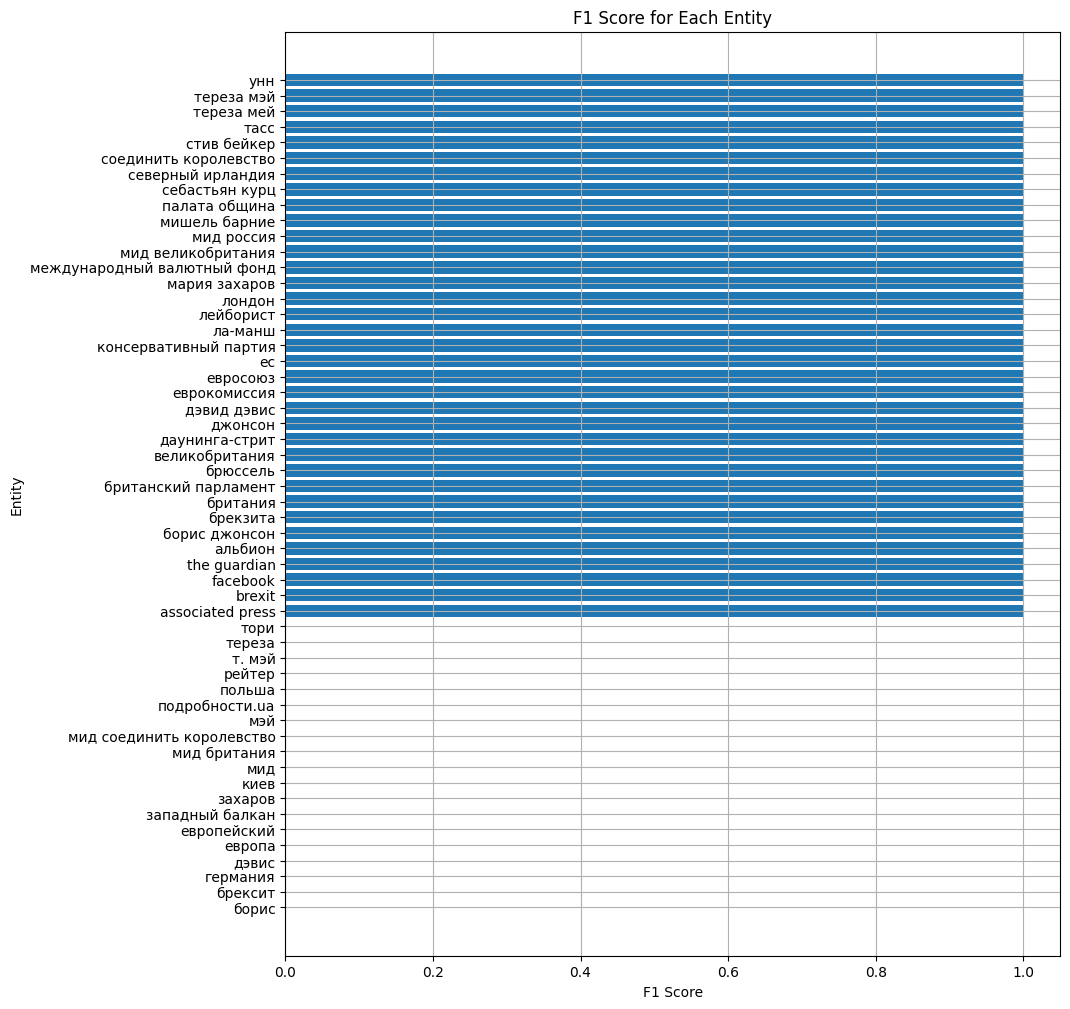

In [26]:
import matplotlib.pyplot as plt
entities_f1, entities = zip(*sorted(zip(entities_f1, entities)))

plt.figure(figsize=(10, 12))
plt.barh(entities, entities_f1)
plt.title("F1 Score for Each Entity")
plt.xlabel("F1 Score")
plt.ylabel("Entity")
plt.grid(True)
plt.show()

Выводы:
- LLMка не знает аббревиатуры МИД (партия отнимать одну плошку борща, вам рейтинг понижен)
- Разметка похоже тоже не совсем точная, раз уж в ней встретился сайт
- брексит по русски не понимает, а по английски не понимает (как обычно croos-lingual проблемы)


## 7. Зависимость от длины документа

Видим, что какие-то паттерны есть: чем меньше длина, тем выше метрики (меньше вероятность ошибиться и в среднем меньше сущностей в документах).

И, соответственно, чем длиннее документ, тем больше сущностей и легче ошибиться.

Тем не менее видим, что в даже среднем документе на 1000 символов.


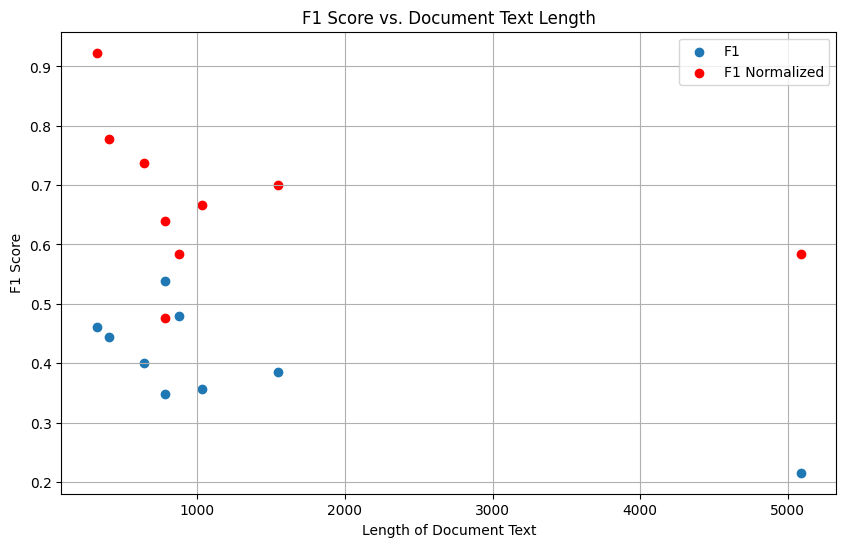

In [27]:
import matplotlib.pyplot as plt

df["text_length"] = df["document_text"].apply(len)

plt.figure(figsize=(10, 6))
plt.scatter(df["text_length"], df["f1"])
plt.scatter(df["text_length"], df["f1_normalized"], c="red")
plt.title("F1 Score vs. Document Text Length")
plt.xlabel("Length of Document Text")
plt.ylabel("F1 Score")
plt.legend(["F1", "F1 Normalized"], loc="upper right")
plt.grid(True)
plt.show()

## 8. Анализ

- ВОЗМОООООЖНО, может всё таки не пихать LLM везде и попробовать найти данные для дообучения RuBERTa. Если найдём данные, то сможем дешевле в последствии справляться с задачей.

- Также стоит отменить, что возможно не стоит использовать pymorphy для приведения к нормальной форме. Взамен можно учитывать как раз таки все предсказания в их форме, что уменьшит метрики но улучшит скорость.

- Длину можно измерять не по символам а по словам.

- Также метрику можно выбрать с нормировкой отсительно длины.


## 9. Итог

- Всё таки выбрал использовать API, а не ручками. Кодом, во-первых, удобнее и практичнее (можно строго задать температуру 0, для жадного декодирования), а, во-вторых, ручками кринж. На работе так точно делаться не будет.
- Час побадался с сертификатом ssl, а потом вспомнил про упоминание, что работает только с сертификатом минцифры и починил всё за 5 минут.
- Наши любимые метрики, есть пространство для улучшения.
